# Evaluating the Performance of MiDaS on Drone Data
---

# 1. Gather Data

Here you can configure the script to work with your data.

In [9]:
import os
import rosbag
import matplotlib.pyplot as plt
import numpy as np
import run
import pickle
import eval_utils as eval_utils

bag_file_name = 'test3.bag'         # name of bag file inside folder "drone_data"
data_filename = 'data.pickle'


topic_cam1 = '/d455/infra1/image_rect_raw'
topic_cam2 = '/d455/infra2/image_rect_raw'
topic_camdepth = '/d455/depth/image_rect_raw'

cam1rgb_key = 'cam1'
cam2rgb_key = 'cam2'
cam1depthestimate_key = 'depth_estimate1'
camdepth_key = 'depth_rs'

# running MiDaS
input_path = 'input'
output_path = 'output'


# model_path = 'weights/dpt_large_384.pt'
# model_type = 'dpt_large_384'
model_path = 'weights/midas_v21_small_256.pt'
model_type = 'midas_v21_small_256'


'''------------------------------------------
        Parameters for MiDaS
------------------------------------------'''
optimize=False
side=False
height=None
square=False
grayscale=True # Realsense output is grayscale


# get the current test_run
test_run = eval_utils.check_bag_file(bag_file_name)

In this run of the script we are investigating bag-file 'test3'.
In case the analysis has already been performed and data has been saved, the saved data will be used to save computational time.


In [16]:
# get timestamps
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

timestamps_cam1     = []
timestamps_cam2     = []
timestamps_camdepth = []

for msg in bag.read_messages(topics=[topic_cam1]):
    timestamps_cam1.append(msg.timestamp.to_sec())

for msg in bag.read_messages(topics=[topic_cam2]):
    timestamps_cam2.append(msg.timestamp.to_sec())

for msg in bag.read_messages(topics=[topic_camdepth]):
    timestamps_camdepth.append(msg.timestamp.to_sec())

## 1.1 Gathering Drone Footage

In [3]:
# get image data from rosbag
image_data_infra1_np, image_data_infra2_np, height, width = eval_utils.get_image_data(bag_file_name,topic_cam1,topic_cam2)

# add data to pickle if not done already
eval_utils.update_data(cam1rgb_key, data_filename, test_run, model_type, image_data_infra1_np)
eval_utils.update_data(cam2rgb_key, data_filename, test_run, model_type, image_data_infra2_np)

The bags contain 843 and 840 frames for the given topics.
'Data' already contained data for 'test3'.
'Data' also already contained data for 'midas_v21_small_256'.
Added 'cam1' to 'midas_v21_small_256' in 'test3'.
'data' saved.
'Data' already contained data for 'test3'.
'Data' also already contained data for 'midas_v21_small_256'.
Added 'cam2' to 'midas_v21_small_256' in 'test3'.
'data' saved.


### Examples

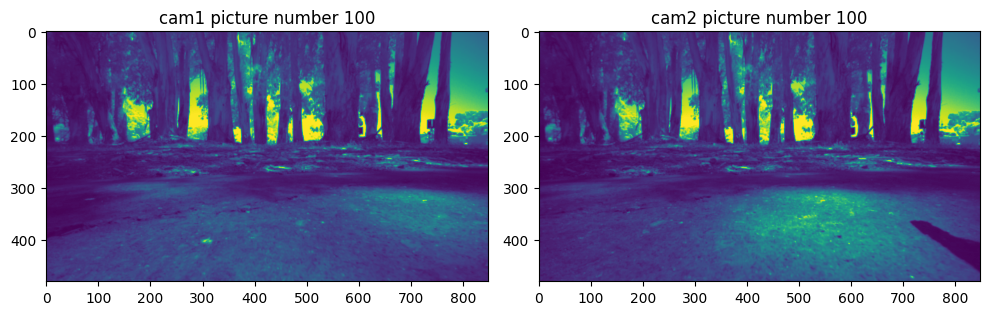

In [4]:
frame1 = 100
frame2 = 100
eval_utils.create_parallel_plots(frame1, frame2, cam1rgb_key, cam2rgb_key, data_filename, test_run, model_type)

## 1.2 Estimating Depth in Drone Footage

In [5]:
# run MiDaS on data from rosbag
run.run(data_filename, test_run, cam1rgb_key, output_path, model_path, model_type, optimize, side, height, square, grayscale)

# Load pickle file
data = eval_utils.load_pickle(data_filename)

Initialize
Device: cpu
Loading weights:  weights/midas_v21_small_256.pt


Using cache found in C:\Users\User/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Model loaded, number of parameters = 21M
'data' loaded.
Start processing
Finished


### Examples

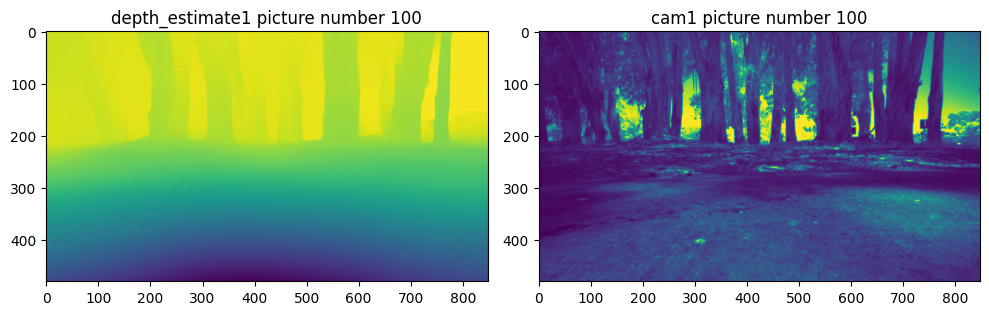

In [6]:
eval_utils.create_parallel_plots(frame1, frame2, 'depth_estimate1', cam1rgb_key, data_filename, test_run, model_type)

## 1.3 Getting "Real" Depth from Intel RealSense

In [32]:
depth_measurement_images = eval_utils.get_depth_data(bag_file_name,topic_camdepth)
# depth_measurement_images = eval_utils.post_process_depth_data(depth_measurement_images)

# add data to pickle if not done already
eval_utils.update_data(camdepth_key, data_filename, test_run, model_type, depth_measurement_images)

'Data' already contained data for 'test3'.
'Data' also already contained data for 'midas_v21_small_256'.
Added 'depth_rs' to 'midas_v21_small_256' in 'test3'.
'data' saved.


### Examples

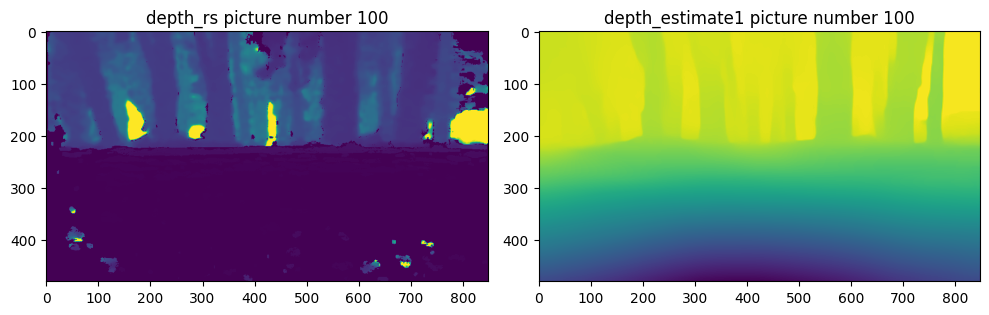

In [33]:
eval_utils.create_parallel_plots(100, 100, camdepth_key,'depth_estimate1', data_filename, test_run, model_type)

Keep in mind that the SAME index of the pictures does not necessarily indicate a correlation with the TIME they were taken.

In the following steps a method will be used to match the "most similar" images. 

---
# 2. Results

In [17]:
# Load pickle file
data = eval_utils.load_pickle(data_filename)

## 2.1 Image Differencing & Image Subtraction

* Image Differencing: two images must first be aligned so that corresponding points coincide
* Image Subtraction: digital numeric value of one pixel or whole image is subtracted from another image

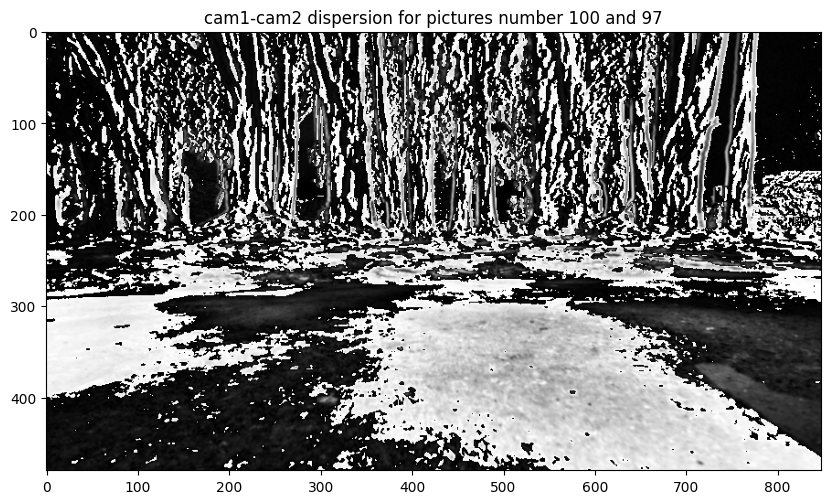

In [18]:
frame1= 100
# get the "most similar image" to a given image by comparing the timestamps of the individual images 
frame2= eval_utils.get_closest_index(frame1, timestamps_cam1, timestamps_cam2)

eval_utils.create_differencing_plot(frame1, frame2, data, cam1rgb_key, cam2rgb_key, test_run, model_type)

## 2.2 Finding Maxima and Minima

### Visualizing Location of Extrema

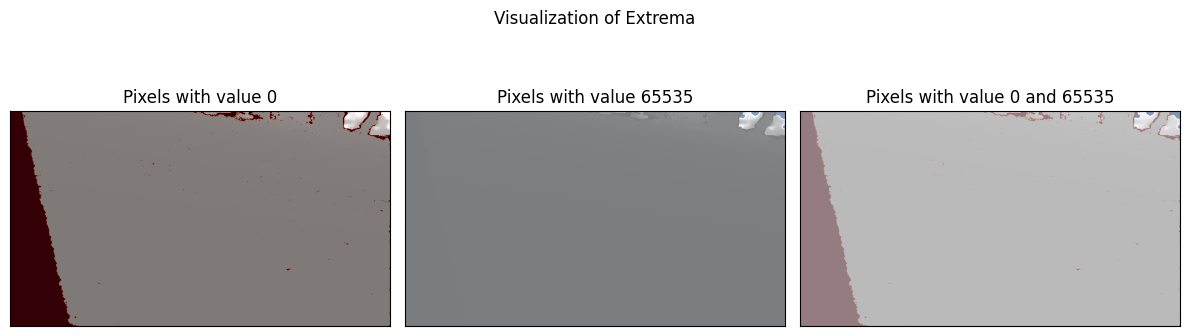

In [24]:
frame_idx = eval_utils.get_closest_index(frame1, timestamps_cam1, timestamps_camdepth)
image = data[test_run][model_type][camdepth_key][654]

eval_utils.plot_extreme_pixels(image)

# num_clusters = 50  # Number of clusters
# circle_scaling_factor = 10  # Scaling the circles around the maxima for better visualization
# eval_utils.plot_clustered_maxima(image, num_clusters, circle_scaling_factor)

## 2.3 Comparing Depth-Estimation to "Ground Truth" from RealSense

1. Finding values that are unreasonable and remove them from the dataset (zeros distance)
2. ...
3. ...
...

### DEPTH-MEASURMENT: Find images where max. depth is not 65535

The frames of the depth measurement that are not containing a single pixel with the value 65535:
[[  652 49873]
 [  653 56379]]


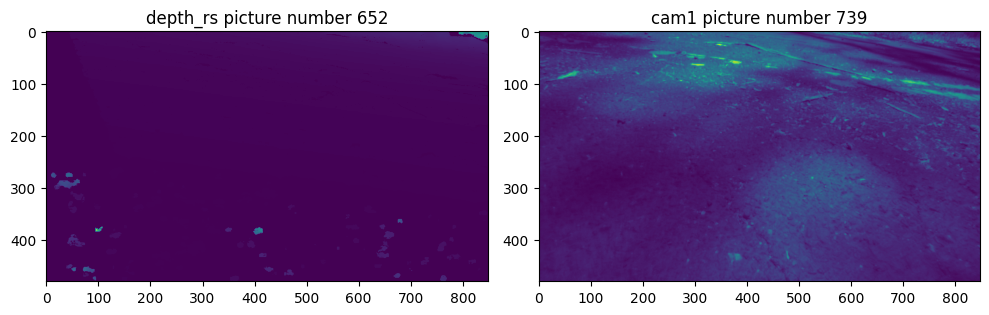

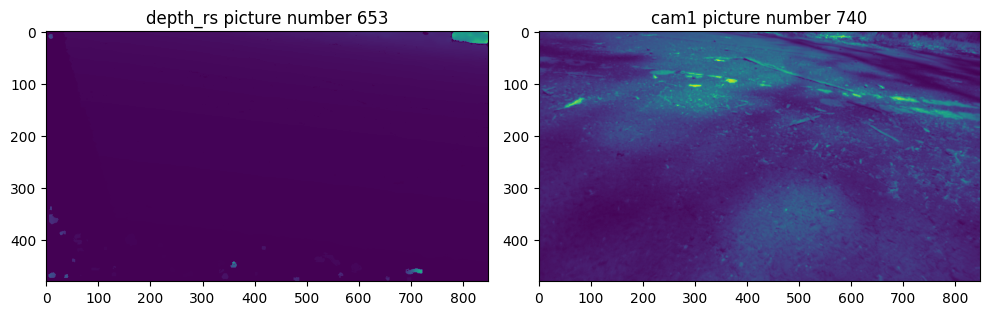

In [36]:
max_depth_measured = eval_utils.get_max_depth_in_frames(data, test_run, model_type, camdepth_key)

indices_not_max_depth_measured = eval_utils.get_indices_images_not_max_depth([max(max_depth_measured)], max_depth_measured)
print('The frames of the depth measurement that are not containing a single pixel with the value 65535:') 
print(indices_not_max_depth_measured)

if indices_not_max_depth_measured.size > 0:
    for i in indices_not_max_depth_measured[:,0]:
        closest_rgb_frame_to_given_depth = eval_utils.get_closest_index(i, timestamps_camdepth, timestamps_cam1)
        eval_utils.create_parallel_plots(i, closest_rgb_frame_to_given_depth, camdepth_key, cam1rgb_key, data_filename, test_run, model_type)

### DEPTH-ESTIMATION: Find images where max. depth is not 65535

In [37]:
max_depth_estimated = eval_utils.get_max_depth_in_frames(data, test_run, model_type, cam1depthestimate_key)

indices_not_max_depth_estimated = eval_utils.get_indices_images_not_max_depth([max(max_depth_estimated)], max_depth_estimated)

print('The frames of the depth measurement that are not containing a single pixel with the value 65535:') 
print(indices_not_max_depth_estimated)

if indices_not_max_depth_estimated.size > 0:
    for i in indices_not_max_depth_estimated[:,0]:
        eval_utils.create_parallel_plots(i, i, cam1depthestimate_key, cam1rgb_key, data_filename, test_run, model_type)

The frames of the depth measurement that are not containing a single pixel with the value 65535:
[]


---
# Work in progress beyond this point: 
---

In [16]:
# # DELETE STUFF FROM DATA
# data[test_run][model_type][cam1depthestimate_key] = []
# eval_utils.save_data(data_filename, data)

### Evaluating performance by Image-Subtraction

In [17]:
# print(data[test_run][model_type][camdepth_key][425][50,550])
# print(data[test_run][model_type][cam1depthestimate_key][123][100,180])

In [18]:
# data[test_run][model_type][camdepth_key][425] = np.where(data[test_run][model_type][camdepth_key][425] == 0, 65535, data[test_run][model_type][camdepth_key][425])

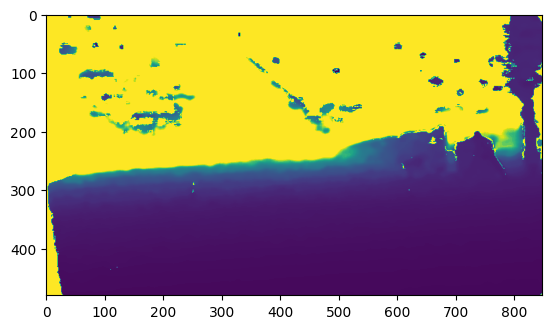

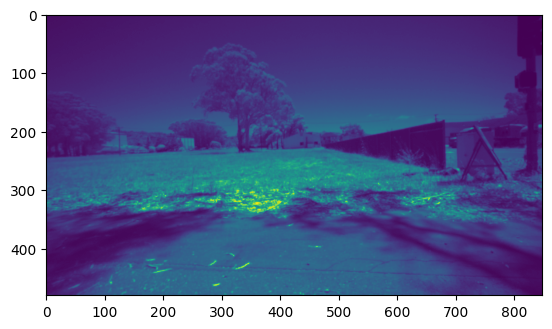

In [19]:
plt.figure() #figsize=(10, 10)
plt.imshow(data[test_run][model_type][camdepth_key][425]) # ,cmap='gray'
# plt.suptitle(cam1 + " picture number " + str(frame1))
plt.show()

plt.figure() #figsize=(10, 10)
plt.imshow(data[test_run][model_type][cam1rgb_key][500]) # ,cmap='gray'
# plt.suptitle(cam1 + " picture number " + str(frame1))
plt.show()

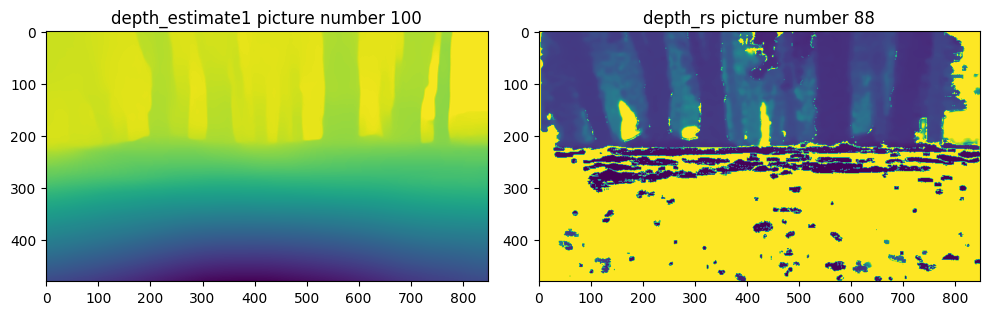

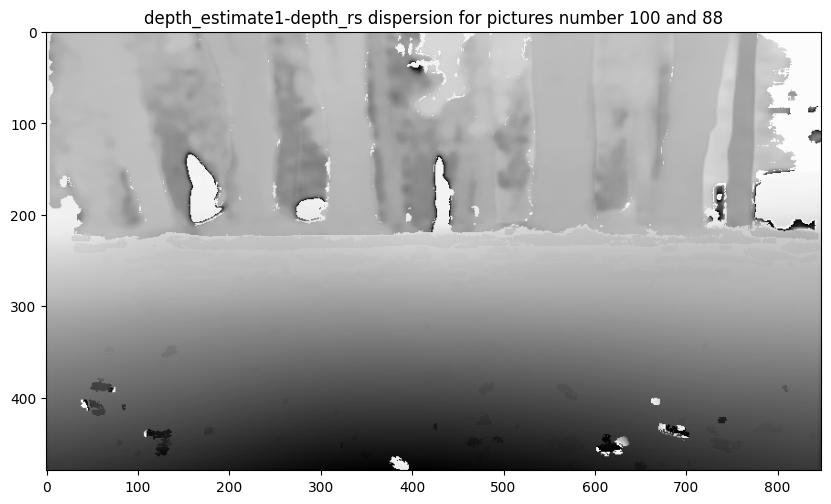

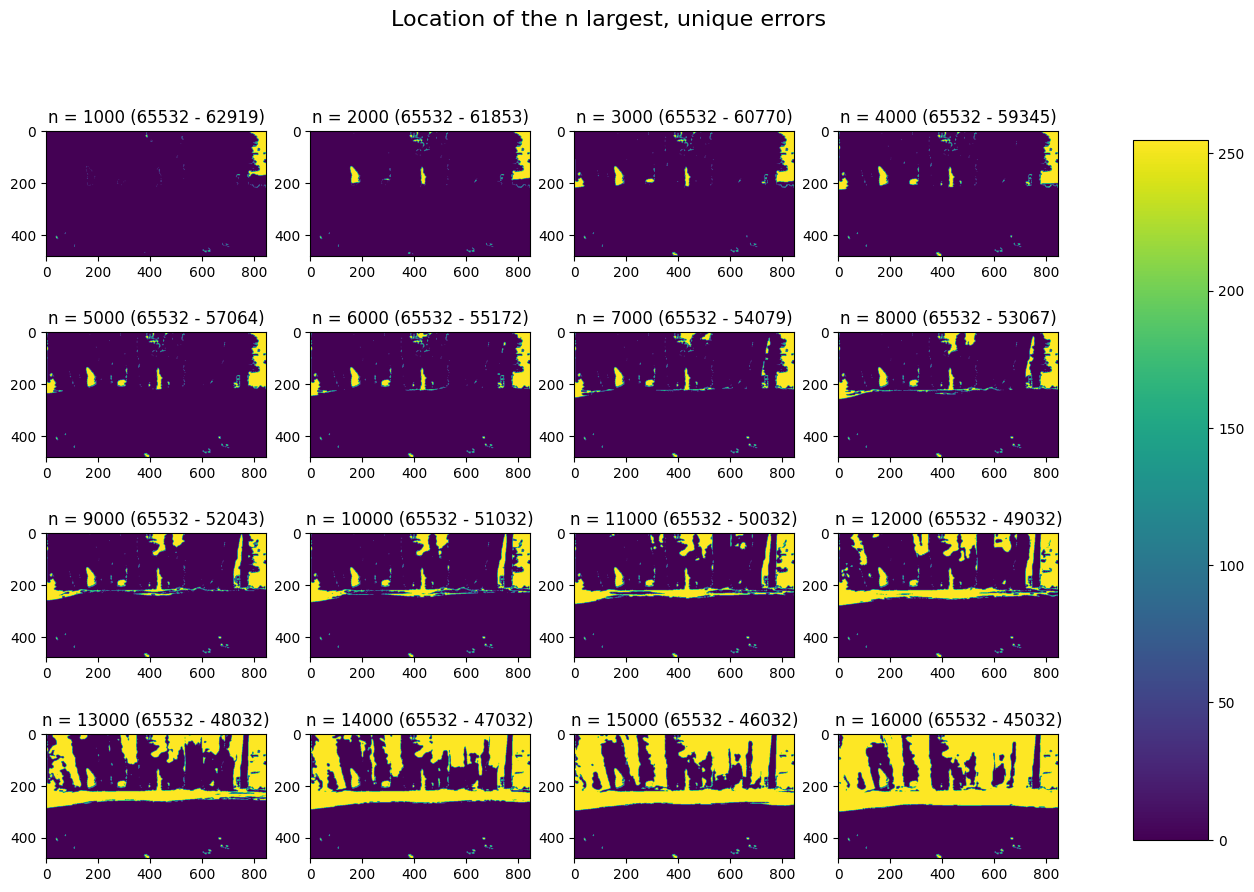

In [20]:
# frame 1: estimate
# frame 2: closest measurement
for frame1_idx in [100]: # TODO: later we look at all frames
    frame2_idx = eval_utils.get_closest_index(frame1_idx, timestamps_cam1, timestamps_camdepth)
    
    eval_utils.create_parallel_plots(frame1_idx, frame2_idx, cam1depthestimate_key, camdepth_key, data_filename, test_run, model_type)
    eval_utils.create_differencing_plot(frame1_idx, frame2_idx, data, cam1depthestimate_key, camdepth_key, test_run, model_type)
    
    eval_utils.visualize_errors(frame1_idx, frame2_idx, data, cam1depthestimate_key, camdepth_key, test_run, model_type)

We can see the following:
<!-- * *HIGH MAGNITUDE ERRORS*: Very <ins>small artifacts</ins> in various places without obvious pattern 
* *MEDIUM MAGNITUDE ERRORS*: Larger areas of <ins>lower accuracy</ins> in the <ins>background</ins>
* *LOW MAGNITUDE ERRORS*: Tendency of errors in the <ins>foreground</ins> -->

* *HIGH MAGNITUDE ERRORS*: Very <ins>small artifacts</ins> in various places without obvious pattern 
* *MEDIUM MAGNITUDE ERRORS*: Larger areas of <ins>lower accuracy</ins> in the <ins>background</ins>
* *LOW MAGNITUDE ERRORS*: Tendency of errors in the <ins>foreground</ins>

---
# Work in progress beyond this point: 
---

In [21]:
'''
We have:
    - depth_estimate_images         [0-65534 or 65535] ?! TODO: check this
    - depth_measurement_images      [0-65535] in mm // TODO: Check if actually mm (could also be value set in camera-options)
'''

'\nWe have:\n    - depth_estimate_images         [0-65534 or 65535] ?! TODO: check this\n    - depth_measurement_images      [0-65535] in mm // TODO: Check if actually mm (could also be value set in camera-options)\n'

In [22]:
# fig = plt.figure(figsize =(10, 7))

# plt.hist(difference_pic)   #, bins=10 

# max_error = difference_pic.max()
# min_error = difference_pic.min()
# text="Histogram of the error between depth estimation and measurement (Range: " + str(min_error) + "-" + str(max_error) + ")"

# plt.title(text)
# plt.show()

In [23]:
# error_matrix = difference_pic

# # Find the unique values in the array
# unique_values = np.unique(error_matrix)

# # Sort the unique values in descending order and get the 10 largest ones
# largest_values = np.sort(unique_values)[::-1][:1000]

# # Create a Boolean mask that sets the largest 10 unique values to True
# mask = np.isin(error_matrix, largest_values)

# difference_pic_zero_extremes = np.zeros_like(error_matrix)
# difference_pic_zero_extremes[mask] = 255


# fig = plt.figure(figsize =(15, 15))
# plt.imshow(difference_pic_zero_extremes)
# plt.show()

In [24]:
# error_matrix = difference_pic

# # Find the unique values in the array
# unique_values = np.unique(error_matrix)

# # Sort the unique values in descending order and get the 10 largest ones
# largest_values = np.sort(unique_values)[::-1][:3500]

# # Create a Boolean mask that sets the largest 10 unique values to True
# mask = np.isin(error_matrix, largest_values)

# difference_pic_zero_extremes = np.zeros_like(error_matrix)
# difference_pic_zero_extremes[mask] = 255


# fig = plt.figure(figsize =(15, 15))
# plt.imshow(difference_pic_zero_extremes)
# plt.show()

# ToDo's
---
* Analyze Timing
    * get time of LEFT and RIGHT frames
* Second Performance Analysis
    * Add function that takes pictures with similar timestamp
    * Compare performance again

###  Finding the indices where the ground truth is best comparable with the depth estimation, because they have been taken at a similar time.

In [25]:
bag = rosbag.Bag(os.path.join('drone_data', bag_file_name))

timestamps_cam1 = []
timestamps_cam2 = []

for msg in bag.read_messages(topics=[topic_cam1]):
    timestamps_cam1.append(msg.timestamp.to_sec())

for msg in bag.read_messages(topics=[topic_camdepth]):
    timestamps_cam2.append(msg.timestamp.to_sec())

In [26]:
def find_indices(array1, array2, threshold):
    indices = []
    for i in range(len(array1)):
        for j in range(len(array2)):
            if abs(array1[i] - array2[j]) <= threshold:
                indices.append((i, j))
    return indices

# Example usage
array1 = np.array(timestamps_cam1)
array2 = np.array(timestamps_cam2)
threshold = 0.0001

indices = find_indices(array1, array2, threshold)
print(indices)

[(297, 266)]


In [27]:
# d_timestamps = []

# for idx, timestamp in enumerate(timestamps[0:-1]): 
#     d_timestamps.append(timestamps_cam1[idx+1]-timestamps_cam1[idx])


In [28]:
'''
We have:
    - depth_estimate_images         [0-65534 or 65535] ?! TODO: check this
    - depth_measurement_images      [0-65535] in mm // TODO: Check if actually mm (could also be value set in camera-options)
'''
# max_depth = depth_measurement_images[idx_analysed_frame].max()
# difference_pic_zero = depth_estimate_images[idx_analysed_frame]/255 + depth_measurement_images[idx_analysed_frame]/max_depth

max_measured_depth = data[test_run][model_type]['depth_rs'][297].max()
print('Maximum measured depth: ' + str(max_measured_depth))

max_estimated1_depth = data[test_run][model_type]['depth_estimate1'][266].max()
# max_estimated2_depth = data[test_run][model_type]['depth_estimate1'][idx_analysed_frame].max()
print('Maximum estimated depth: ' + str(max_estimated1_depth))



difference_pic = data[test_run][model_type]['depth_estimate1'][297]/max_estimated1_depth + data[test_run][model_type]['depth_rs'][266]/max_measured_depth
difference_pic.max()

Maximum measured depth: 65535
Maximum estimated depth: 65535


1.997787441824979

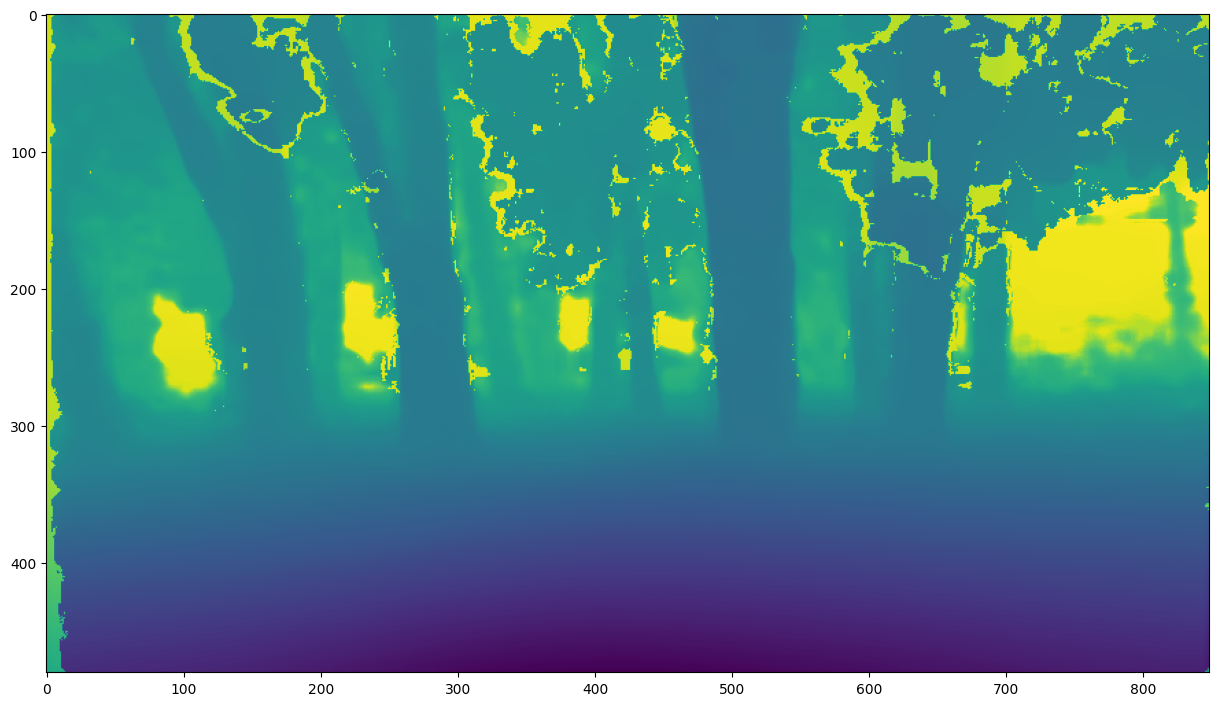

In [29]:
fig = plt.figure(figsize =(15, 15))
plt.imshow(difference_pic) # cmap='gray'
plt.show()

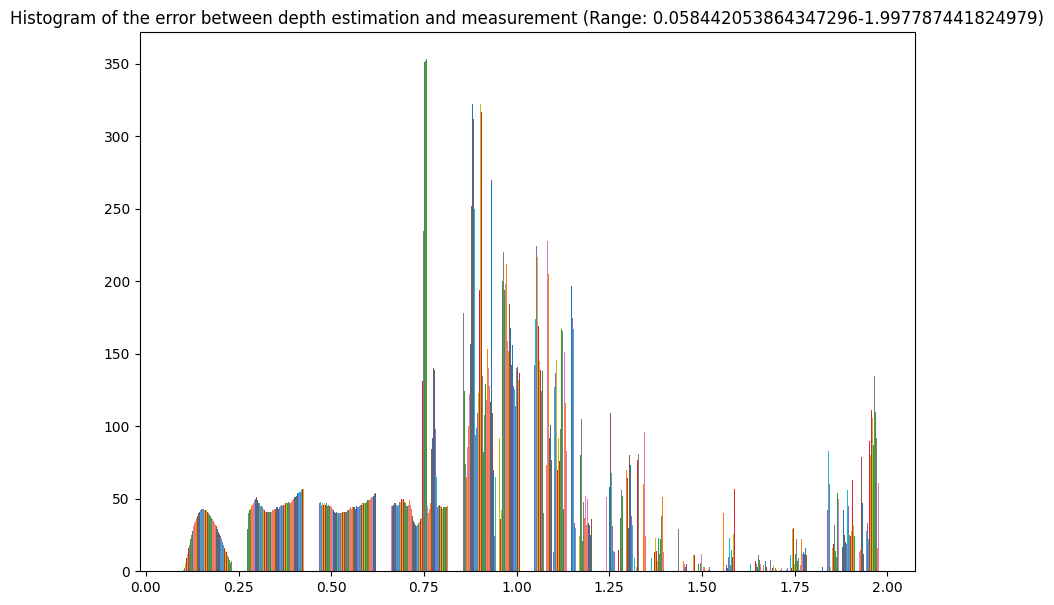

In [30]:
fig = plt.figure(figsize =(10, 7))

plt.hist(difference_pic)   #, bins=10 

max_error = difference_pic.max()
min_error = difference_pic.min()
text="Histogram of the error between depth estimation and measurement (Range: " + str(min_error) + "-" + str(max_error) + ")"

plt.title(text)
plt.show()

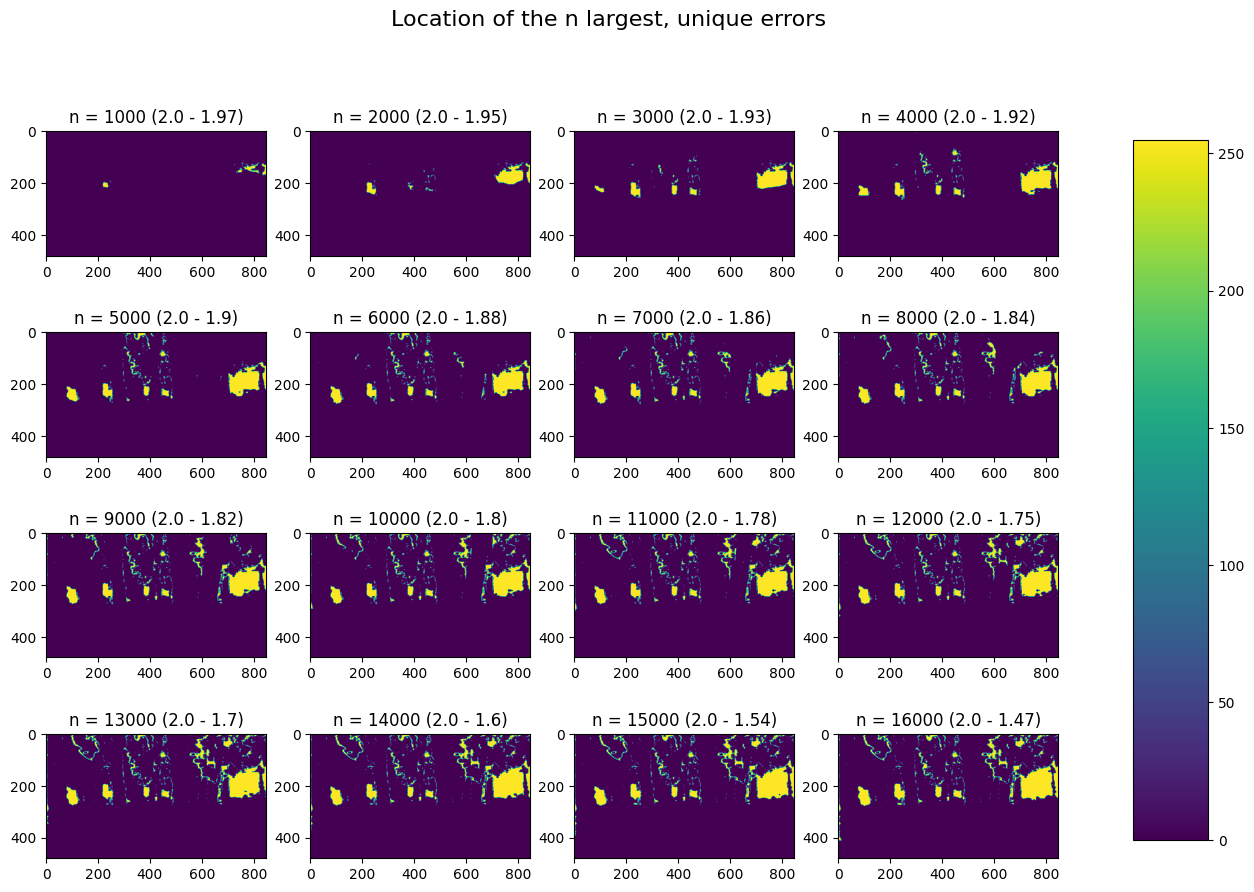

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize =(15, 10))
for idx, ax in enumerate(axes.flat):

    error_matrix = difference_pic

    # Find the unique values in the array
    unique_values = np.unique(error_matrix)

    # Sort the unique values in descending order and get the 'largest_amount' largest ones
    largest_amount = 1000*(idx+1)
    largest_values = np.sort(unique_values)[::-1][:(largest_amount)]

    # Create a Boolean mask that sets the largest 10 unique values to True
    mask = np.isin(error_matrix, largest_values)

    difference_pic_zero_extremes = np.zeros_like(error_matrix)
    difference_pic_zero_extremes[mask] = 255

    # fig = plt.figure(figsize =(15, 15))
    roundingval = 2
    text = "n = "+str(largest_amount) + " (" + str(round(largest_values[0],roundingval)) + " - " +str(round(largest_values[-1],roundingval)) + ")"
    ax.set_title(text)   
    
    im = ax.imshow(difference_pic_zero_extremes, vmin=0, vmax=255)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Location of the n largest, unique errors', fontsize=16)
plt.show()
# plt.colorbar(label="error", orientation="horizontal")

It is obvious that the step of only considering data from similar points in time is smart.